In [ ]:
# Install specialized NLDR & Wasserstein packages (if not installed already)
!yes | pip install -U --quiet https://github.com/PythonOT/POT/archive/master.zip 
!yes | pip install -U --quiet pyDiffMap
# Update matplotlib to use subplot_mosaic. 
!yes | pip install -U --quiet matplotlib==3.5

In [1]:
import sys
sys.path.append("../") # Add base code dir to import wassmap (note: not necessary if wassmap was installed using pip)

import wassmap as wm
import numpy as np
import networkx as nx
import time
import sklearn
from sklearn import manifold as man
from sklearn.decomposition import PCA
from pydiffmap import diffusion_map as dm

import matplotlib.pyplot as plt

from torch import HalfStorage

In [2]:
# Some global figure settings
%matplotlib inline
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
        'axes.titlesize': 32
         }

plt.rcParams.update(params)
 
font = {'family':'serif','weight':'normal','size':12}
plt.rc('font',**font)

np.set_printoptions(edgeitems=30, linewidth=100000,formatter=dict(float=lambda x: "%.3g" % x))

First, we'll demonstrate the image generation capabilities

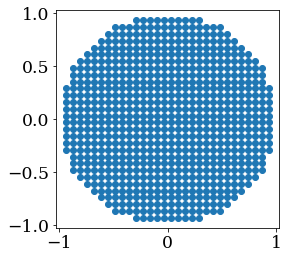

In [3]:
# Generate and plot a circle point cloud 
num_samplepoints = 32
x = wm.generate_circle([0,0],1,samples=num_samplepoints)
fig,ax = plt.subplots()
ax.scatter(x[:,0],x[:,1])

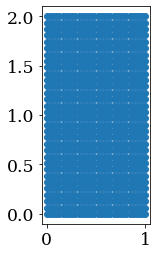

In [4]:
# Generate and plot a rectangle point cloud 
num_samplepoints = 32
x = wm.generate_rectangle(1,2,[0,0],samples=num_samplepoints)
fig,ax = plt.subplots()
ax.scatter(x[:,0],x[:,1])
ax.set_aspect(1)

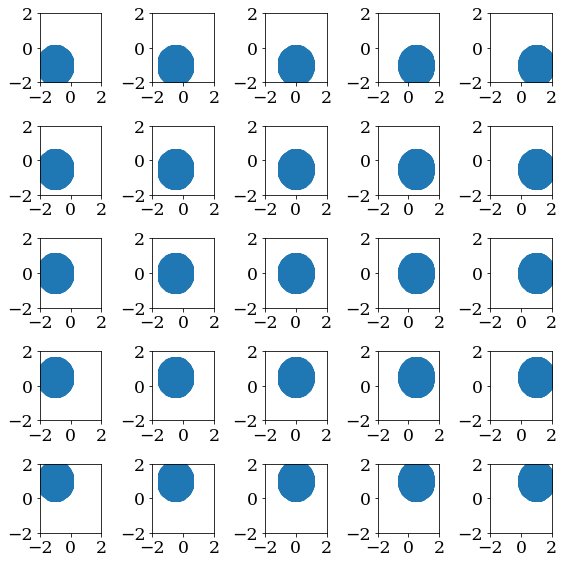

In [5]:
# Generate and plot a set of translated set of circles
# Note: we first generate point clouds, then convert the point clouds to voxel reps

# Generate base circle
num_samplepoints = 64
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 3
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,x) 
xx = np.reshape(xx,(num_samp,1))
yy = np.reshape(yy,(num_samp,1))
translates = np.zeros((num_samp,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
# Generate translation images and image tensor
trans_images = []
for i in range(num_samp):
    img = np.concatenate((wm.translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)
    
# Generate voxel images (for ISOmap)
nvox = 256
xg = np.linspace(-2,2,nvox)
xxg,yyg = np.meshgrid(xg,xg,indexing='ij')
grid = np.stack((xxg,yyg))
# Format required for our voxel-based methods
trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
# Format required for scikitlearn
vox_matrix = np.zeros((num_translates**2,nvox*nvox))
for i in range(num_translates**2):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix[i,:] = np.reshape(trans_images_vox[:,:,i],(1,nvox*nvox))
    
fig1,ax1 = plt.subplots(num_translates,num_translates,figsize=[8,8])
k = 0
for i in range(num_translates):
    for j in range(num_translates):
        ax1[i,j].scatter(trans_images[k][:,0],trans_images[k][:,1])
        ax1[i,j].set_xlim([-2,2])
        ax1[i,j].set_ylim([-2,2])
        k = k+1
fig1.tight_layout()

fig2,ax2 = plt.subplots(num_translates,num_translates,figsize=[8,8])
k = 0
for i in range(num_translates):
    for j in range(num_translates):
        ax2[i,j].imshow(trans_images_vox[k])
        ax2[i,j].set_xlim([-2,2])
        ax2[i,j].set_ylim([-2,2])
        k = k+1
fig2.tight_layout()

In [7]:
### FIGURE 1: Circle translate test 1:OVERLAPPING IMAGES::Computations
# NOTE: In this test, the translation grid is such that the resulting synthetic 
# images will overlap.  Thus, Isomap is at least well-defined (i.e. there are meaningful geodesics)

# Generate base circle
num_samplepoints = 64
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 5
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,x) 
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
# Generate translation images and image tensor
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((wm.translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
xg = np.linspace(-2,2,nvox)
xxg,yyg = np.meshgrid(xg,xg,indexing='ij')
grid = np.stack((xxg,yyg))
# Format required for our voxel-based methods
trans_images_vox = np.zeros((nvox,nvox,num_translates**2))
# Format required for scikitlearn
vox_matrix = np.zeros((num_translates**2,nvox*nvox))
for i in range(num_translates**2):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix[i,:] = np.reshape(trans_images_vox[:,:,i],(1,nvox*nvox))
    
# Compute Wasserstein square distance matrix
#tic = time.perf_counter()
#wass_p = 2.0
#Wass_distance_trans = wm.wass_matrix(trans_images,squared=True,geodesic=False,p=wass_p)
#toc = time.perf_counter() - tic
#print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
#WassEmbedding_trans = wm.mds(Wass_distance_trans,squared=True)


# Compute ISOMAP embedding using sklearn 
isomap_k = 5
EucEmbedding_skl = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap) using sklearn
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=10).fit_transform(vox_matrix)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding = mydmap.fit_transform(vox_matrix)

/Users/nick/opt/anaconda3/lib/python3.9/site-packages/ot/lp/__init__.py:554: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 25) in 284.8736 seconds


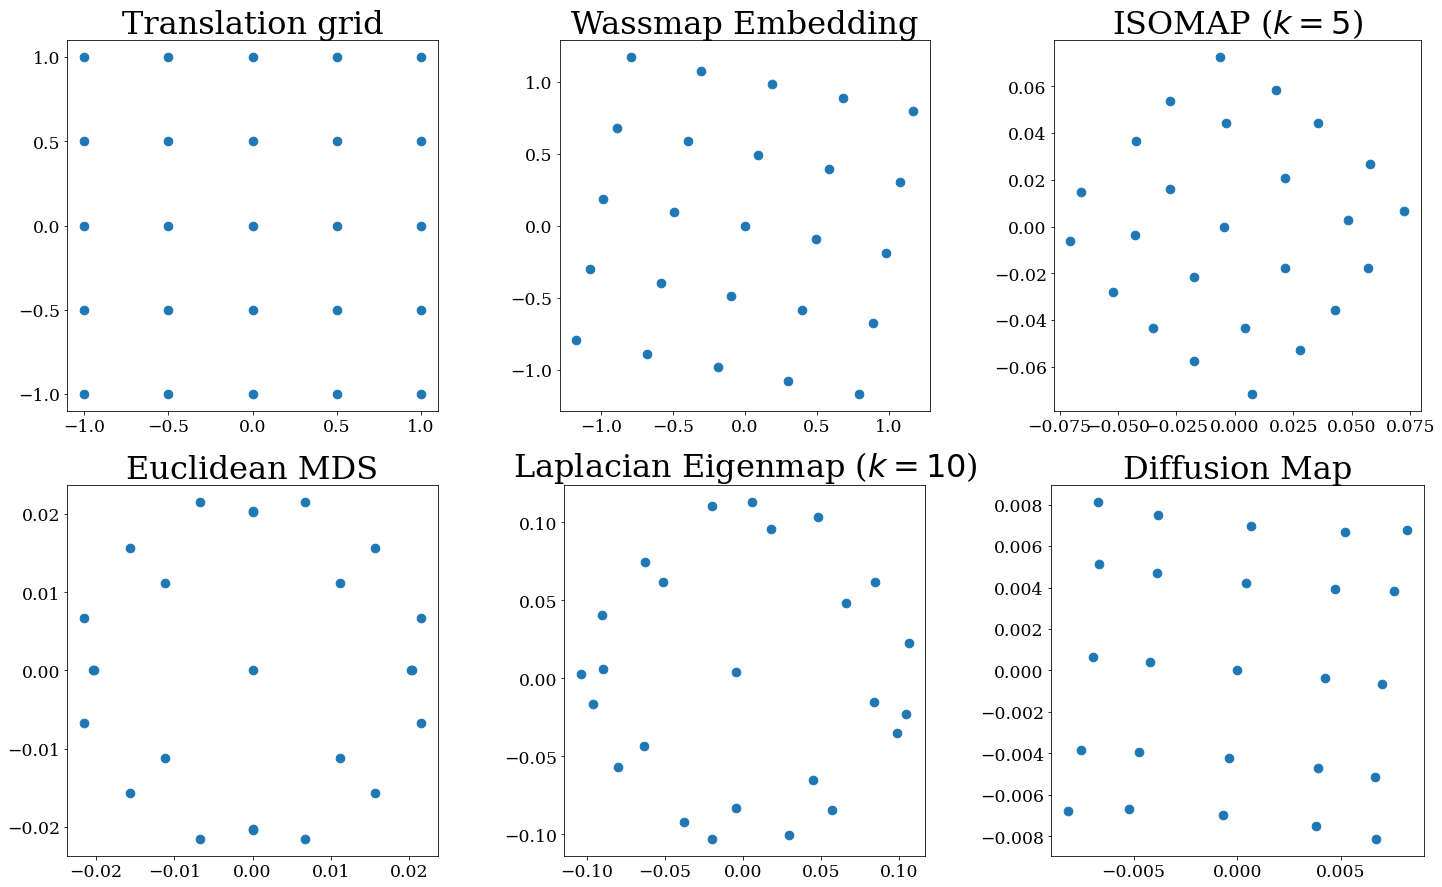

In [11]:
### FIGURE 1: Circle translate test 1:OVERLAPPING IMAGES:Plotting

# Create the plot objects 
fig1,ax1 = plt.subplots(2,3,figsize=(25,15))

# Plot the translation set 
ax1[0,0].scatter(translates[:,0],translates[:,1],s=75)
ax1[0,0].set_aspect('equal')
ax1[0,0].set_title('Translation grid')
ax1[0,0].set_xticks(x)
ax1[0,0].set_yticks(x)
# Plot a voxel image
#ax1[0,1].imshow(trans_images_vox[:,:,0],origin='lower',extent=(-2,2,-2,2))
#ax1[0,1].set_aspect('equal')
#ax1[0,1].set_title('Image Sample (Voxelized)')
# Plot the Wassmap embedding
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
ax1[0,1].scatter(scatter_x,scatter_y,s=75)
ax1[0,1].set_aspect('equal')
ax1[0,1].set_title('Wassmap Embedding')
# Plot the ISOMAP embedding
ax1[0,2].scatter(EucEmbedding_skl[:,0], EucEmbedding_skl[:,1],s=75)
ax1[0,2].set_aspect('equal')
ax1[0,2].set_title("ISOMAP ($k=%i$)"%isomap_k)
# Plot the Euclidean MDS embedding
scatter_x = EucEmbedding[:,0]
scatter_y = EucEmbedding[:,1]
ax1[1,0].scatter(scatter_x,scatter_y,s=75)
ax1[1,0].set_aspect('equal')
ax1[1,0].set_title('Euclidean MDS')
# Plot the spectral embedding 
ax1[1,1].scatter(SpecEmbedding[:,0],SpecEmbedding[:,1],s=75)
ax1[1,1].set_aspect('equal')
ax1[1,1].set_title('Laplacian Eigenmap ($k=10$)')
# Plot the diffusion map embedding 
ax1[1,2].scatter(DMapEmbedding[:,0],DMapEmbedding[:,1],s=75)
ax1[1,2].set_aspect('equal')
ax1[1,2].set_title('Diffusion Map')

# Save the figure to google drive 
fig1.savefig('./fig1.pdf',bbox_inches='tight')

i = 0
minimum nonzero distance = 0.6667
i = 1
minimum nonzero distance = 0.6667
i = 2
minimum nonzero distance = 0.6667
i = 3
minimum nonzero distance = 0.6667


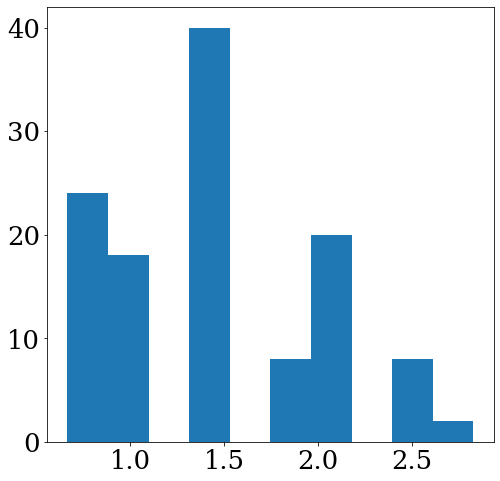

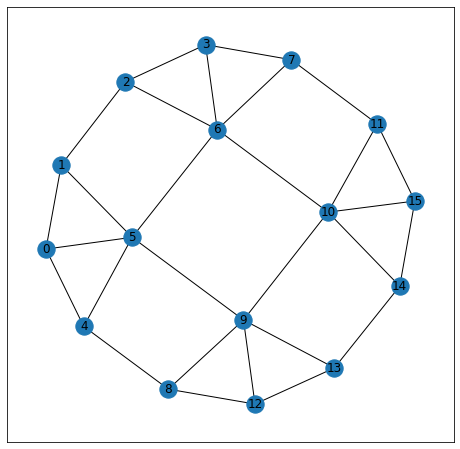

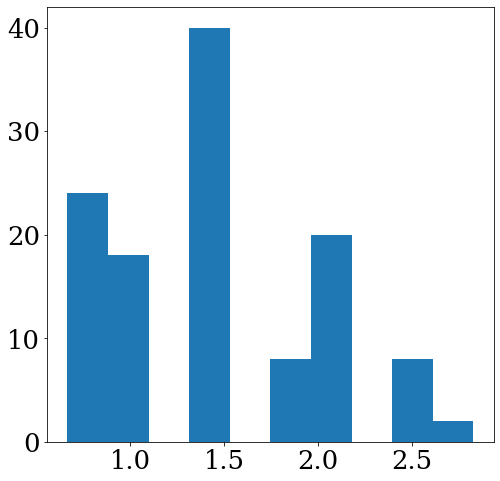

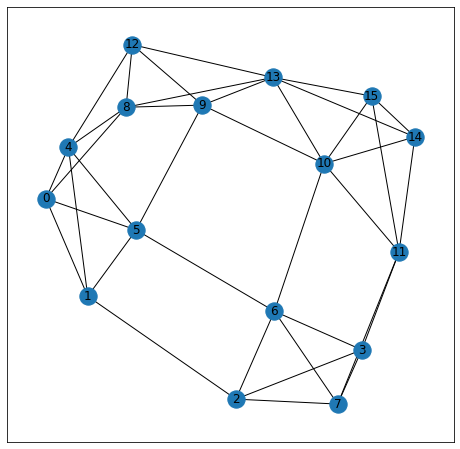

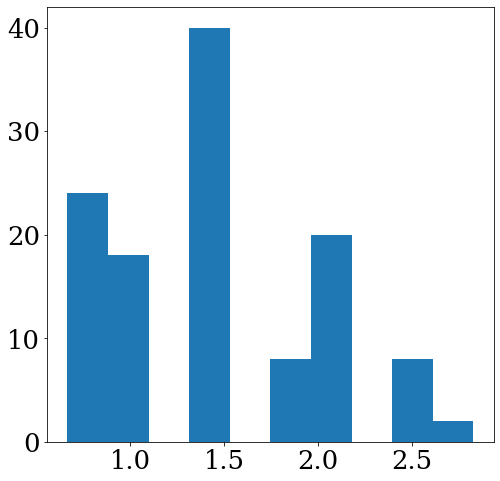

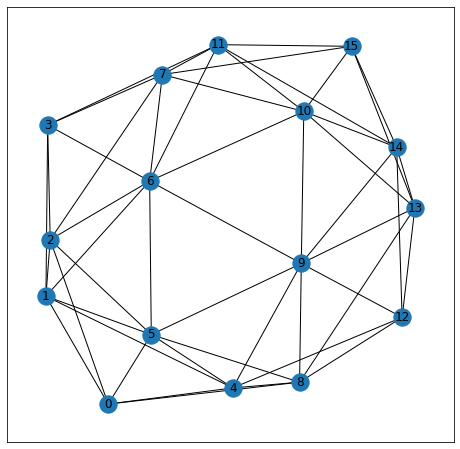

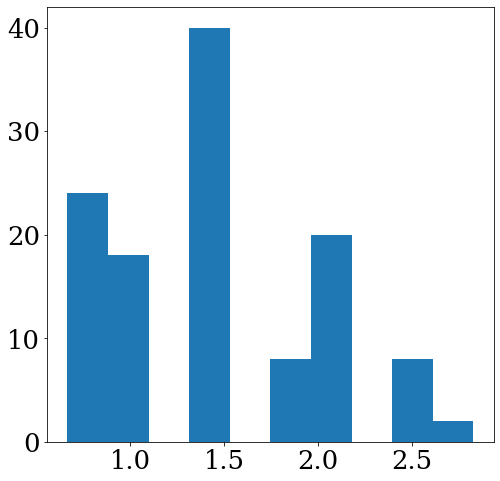

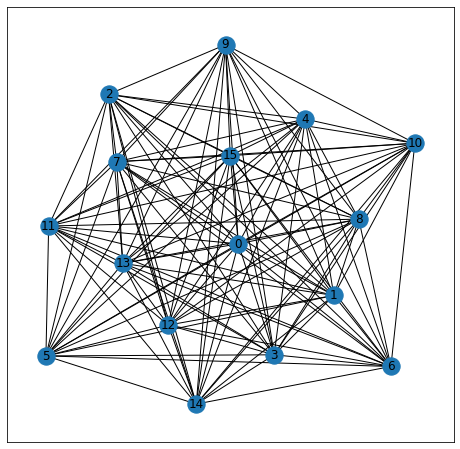

In [ ]:
## Translate manifold with geodesics (showing that geodesics are not needed for this manifold)

# Generate base circle
num_samplepoints = 32
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set
num_translates = 4
num_samp = num_translates**2
x = np.linspace(-1,1,num=num_translates)
xx,yy = np.meshgrid(x,x) 
xx = np.reshape(xx,(num_translates**2,1))
yy = np.reshape(yy,(num_translates**2,1))
translates = np.zeros((num_translates**2,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]
    
# Generate translation images and image tensor
trans_images = []
for i in range(num_translates**2):
    img = np.concatenate((wm.translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Compute the embeddings for different epsilon values (corresponding to different graph constructions)
wass_epsilon = [0,1,1.5]
wass_k       = [3,4,5,15]
embeddings = list()
graphs     = list()
for i in range(len(wass_k)):
    print("i = %i"%i)
    #Wass_distance_geo,G = wm.Wasserstein_Matrix(trans_images,squared=True,geodesic=True,plot=True,eps=wass_epsilon[i],returngraph=True)
    Wass_distance_geo,G = wm.Wasserstein_Matrix(trans_images,squared=True,geodesic=True,plot=True,k=wass_k[i],method='knn',returngraph=True)
    embeddings.append(wm.MDS(Wass_distance_geo,squared=True))
    graphs.append(G)

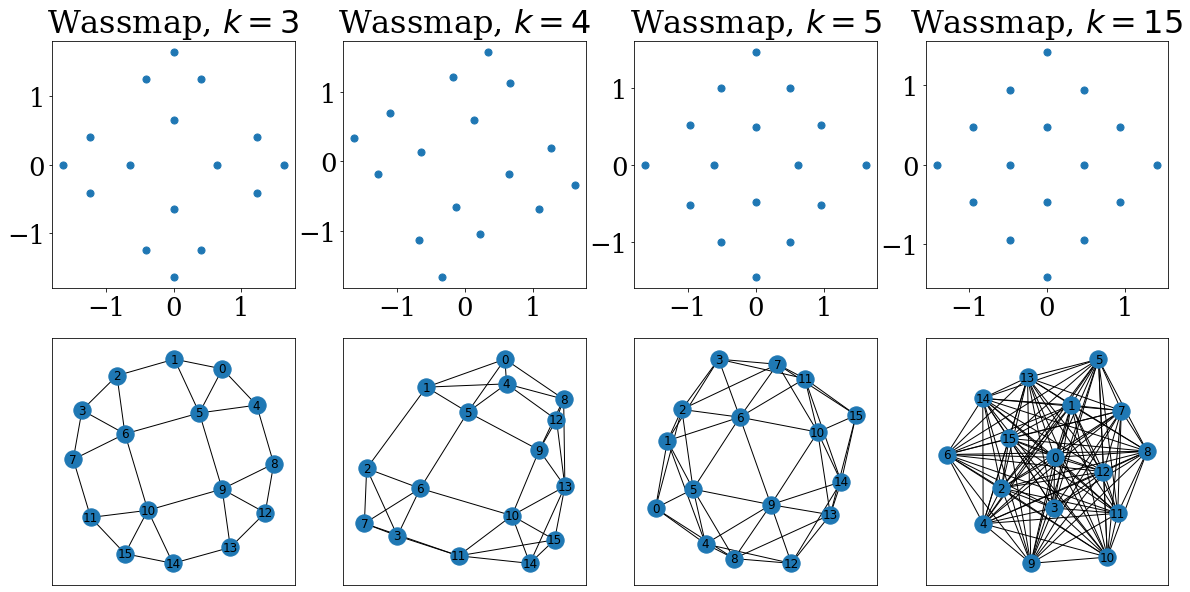

In [ ]:
fig,ax = plt.subplots(2,len(wass_k),figsize=(20,10))
for i in range(len(wass_k)):
    scatter_x = embeddings[i][:,0]
    scatter_y = embeddings[i][:,1]
    ax[0,i].scatter(scatter_x,scatter_y,s=50)
    #ax[0,i].set_aspect('equal')
    #ax[0,i].set_title('Wassmap Embedding, $\epsilon = %1.2f$'%wass_epsilon[i])
    ax[0,i].set_title('Wassmap, $k = %i$'%wass_k[i])
    G = graphs[i]
    nx.draw_networkx(G,pos=nx.spring_layout(G),ax=ax[1,i])
    #ax[1,i].set_aspect('equal')

# Save the figure to google drive 
fig.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig1_geodesics.pdf',bbox_inches='tight')

In [ ]:
### FIGURE 2: Circle translate test 2:DOUBLE GRID::Computations
#   Translation set is a grid in 2 disjoint rectangles: [-20,-10]x[-5,5] union [10,20]x[-5,5]

# Generate circle
num_samplepoints = 64
circ = wm.generate_circle([0,0],1,samples=num_samplepoints)

# Generate translation set 
num_translates = 6
num_samp = 2*num_translates**2
x = np.hstack((np.linspace(-7,-2,num=int(num_translates)),np.linspace(2,7,num=int(num_translates))))
y = np.linspace(-2.5,2.5,num=num_translates)
np.random.shuffle(x) # Shuffle to make sure the order of the images doesn't matter
np.random.shuffle(y) 
xx,yy = np.meshgrid(x,y) #num_translates x num_translates matrices; each xx,yy entry is a translation vector
xx = np.reshape(xx,(num_samp,1))
yy = np.reshape(yy,(num_samp,1))
translates = np.zeros((num_samp,2))
for i in range(len(xx)):
    translates[i,0] = xx[i]
    translates[i,1] = yy[i]

# Generate translation images and image tensor
trans_images = []
for i in range(num_samp):
    img = np.concatenate((wm.translation(circ,[translates[i,0],translates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    trans_images.append(img)

# Generate voxel images (for ISOmap, eigenmap and diffusion map)
nvox = 256
xg = np.linspace(-7,7,nvox)
yg = np.linspace(-2.5,2.5,nvox)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
# Format required for our voxel-based methods
trans_images_vox = np.zeros((nvox,nvox,num_samp))
# Format required for scikitlearn
vox_matrix = np.zeros((num_samp,nvox*nvox))
for i in range(num_samp):
    pc = trans_images[i]
    trans_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix[i,:] = np.reshape(trans_images_vox[:,:,i],(1,nvox*nvox))

# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_trans = wm.Wasserstein_Matrix(trans_images,squared=True,geodesic=False)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_trans = wm.MDS(Wass_distance_trans,squared=True)

# Compute Euclidean distance matrix and select threshold
# NOTE: if eps is too large, the graph will be disconnected and the distance matrix will have infs. 
# GENERAL STRATEGY: Pick eps to be the largest value such that the graph remains connected 
# You can use the distance histogram to pick this manually (set plot=True in the Euclidean_Matrix call)
euc_matrix = wm.Euclidean_Matrix(trans_images_vox,geodesic=False,squared=True,plot=False)

# Compute the Euclidean MDS embedding
EucEmbedding = wm.MDS(euc_matrix,squared=True)

# Compute isomap using sklearn 
isomap_k = 5
IsomapEmbedding = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap) using sklearn
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=10).fit_transform(vox_matrix)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding = mydmap.fit_transform(vox_matrix)

/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:554: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 72) in 5796.8497 seconds


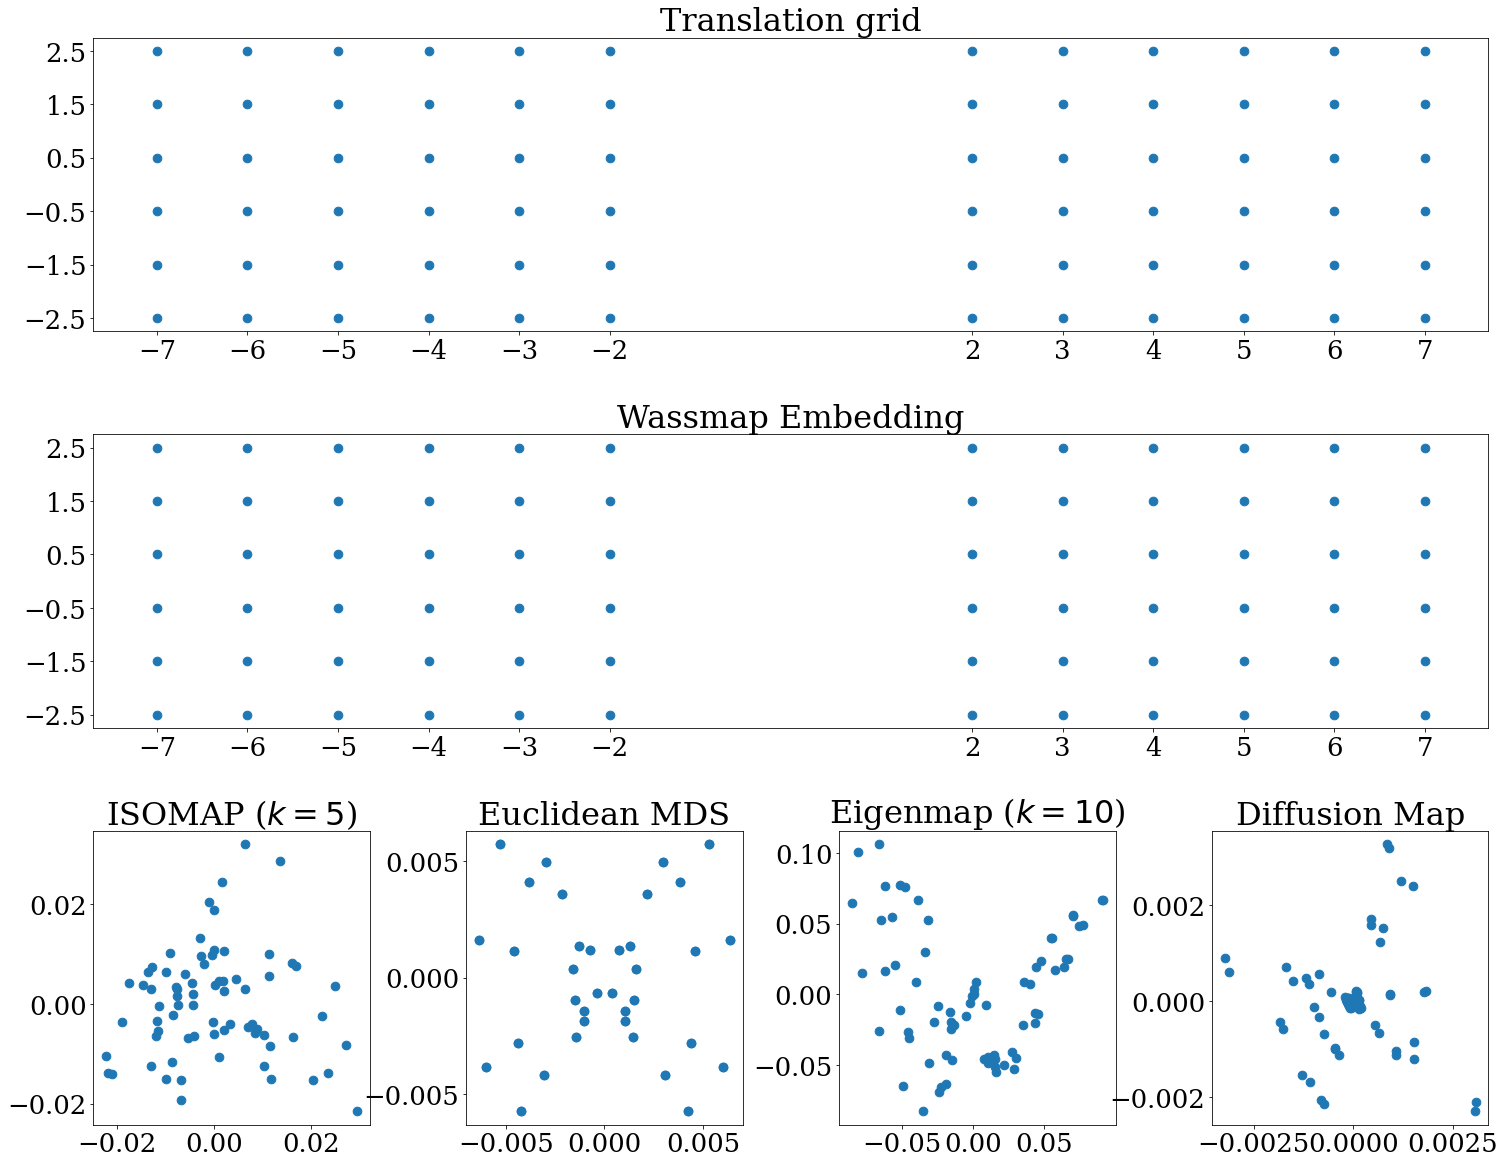

In [ ]:
### FIGURE 2: Circle translate test 2:DOUBLE GRID:Plotting

# Create the plot objects 
#fig2,ax2 = plt.subplots(5,1,figsize=(15,20))

fig2 = plt.figure(figsize=(25,20))
ax2 = fig2.subplot_mosaic(
    """
    AAAA
    BBBB
    CDEF
    """,
    gridspec_kw = {"wspace":0.35,"hspace":0.35}
)

# Plot the translation set 
ax2['A'].scatter(translates[:,0],translates[:,1],s=75)
#ax2['A'].set_aspect('equal')
ax2['A'].set_title('Translation grid')
ax2['A'].set_xticks(x)
ax2['A'].set_yticks(y)

# Plot Wassmap embedding
scatter_x = WassEmbedding_trans[:,0]
scatter_y = WassEmbedding_trans[:,1]
ax2['B'].scatter(scatter_x,scatter_y,s=75)
#ax2['B'].set_aspect('equal')
ax2['B'].set_title('Wassmap Embedding')
ax2['B'].set_xticks(x)
ax2['B'].set_yticks(y)
# Plot the Isomap embedding
ax2['C'].scatter(IsomapEmbedding[:,0], IsomapEmbedding[:,1],s=75)
ax2['C'].set_title("ISOMAP ($k = %i$)"%isomap_k)
# Plot the Euclidean MDS embedding
ax2['D'].scatter(EucEmbedding[:,0], EucEmbedding[:,1],s=75)
ax2['D'].set_title("Euclidean MDS")

# Plot the spectral embedding 
ax2['E'].scatter(SpecEmbedding[:,0],SpecEmbedding[:,1],s=75)
#ax2['D'].set_aspect('equal')
ax2['E'].set_title('Eigenmap ($k=10$)')
# Plot the diffusion map embedding 
ax2['F'].scatter(DMapEmbedding[:,0],DMapEmbedding[:,1],s=75)
#ax2['E'].set_aspect('equal')
ax2['F'].set_title('Diffusion Map')

# Save the figure to google drive 
fig2.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig2.pdf',bbox_inches='tight')

In [ ]:
### FIGURE 3: Circle dilation test 1::Computations
##  

# Generate circle
num_samplepoints = 64
radius = 1
circ = wm.generate_circle([0,0],radius,samples=num_samplepoints)

# Generate dilation set
num_dilates = 5
num_samp = num_dilates**2
x = np.linspace(.5,2,num=num_dilates)
y = np.linspace(.5,4,num=num_dilates)
xx,yy = np.meshgrid(x,y) #num_dilates x num_dilates matrices; each xx,yy entry is a dilation vector
xx = np.reshape(xx,(num_dilates**2,1))
yy = np.reshape(yy,(num_dilates**2,1))
dilates = np.zeros((num_dilates**2,2))
for i in range(len(xx)):
    dilates[i,0] = xx[i]
    dilates[i,1] = yy[i]

# Generate dilation images and image tensor
dil_images = []
for i in range(num_dilates**2):
    img = np.concatenate((wm.dilation(circ,[dilates[i,0],dilates[i,1]]),np.ones((circ.shape[0],1))/circ.shape[0]),axis=1)
    dil_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
nxg = nvox
nyg = nvox

xg = np.linspace(-2,2,nxg)
yg = np.linspace(-4,4,nyg)
xxg,yyg = np.meshgrid(xg,yg,indexing='ij')
grid = np.stack((xxg,yyg))
dil_images_vox = np.zeros((nvox,nvox,num_dilates**2))
vox_matrix = np.zeros((num_samp,nvox*nvox))
for i in range(num_samp):
    pc = dil_images[i]
    dil_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix[i,:] = np.reshape(dil_images_vox[:,:,i],(1,nvox*nvox))

# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance_dil = wm.Wasserstein_Matrix(dil_images,squared=True,geodesic=False)
Wass_distance_p1  = wm.Wasserstein_Matrix(dil_images,squared=True,geodesic=False,p=1)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))



/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:554: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 25) in 764.7953 seconds


/usr/local/lib/python3.7/dist-packages/pydiffmap/kernel.py:198: UserWarning: The BGH method for choosing epsilon assumes a euclidean metric.  However, the metric being used is precomputed.  Proceed at your own risk...
  warnings.warn('The BGH method for choosing epsilon assumes a euclidean metric.  However, the metric being used is %s.  Proceed at your own risk...' % self.metric)


In [ ]:
# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_dil = wm.MDS(Wass_distance_dil,squared=True)
WassEmbedding_p1  = wm.MDS(Wass_distance_p1,squared=True)

# Compute Euclidean distance matrix and Euclidean MDS embedding
euc_matrix = wm.Euclidean_Matrix(dil_images_vox,geodesic=False,squared=True,plot=False)
EucEmbedding = wm.MDS(euc_matrix,squared=True)

# Compute isomap using sklearn 
isomap_k = 5
IsomapEmbedding = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap)
numneighbors = 10
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=numneighbors).fit_transform(vox_matrix)
SpecEmbedding_wass = man.SpectralEmbedding(n_components=2,affinity='precomputed').fit_transform(Wass_distance_dil)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
mydmap_wass = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0,k=10,metric='precomputed')
DMapEmbedding = mydmap.fit_transform(vox_matrix)
DMapEmbedding_wass = mydmap_wass.fit_transform(Wass_distance_dil)

/usr/local/lib/python3.7/dist-packages/pydiffmap/kernel.py:198: UserWarning: The BGH method for choosing epsilon assumes a euclidean metric.  However, the metric being used is precomputed.  Proceed at your own risk...
  warnings.warn('The BGH method for choosing epsilon assumes a euclidean metric.  However, the metric being used is %s.  Proceed at your own risk...' % self.metric)


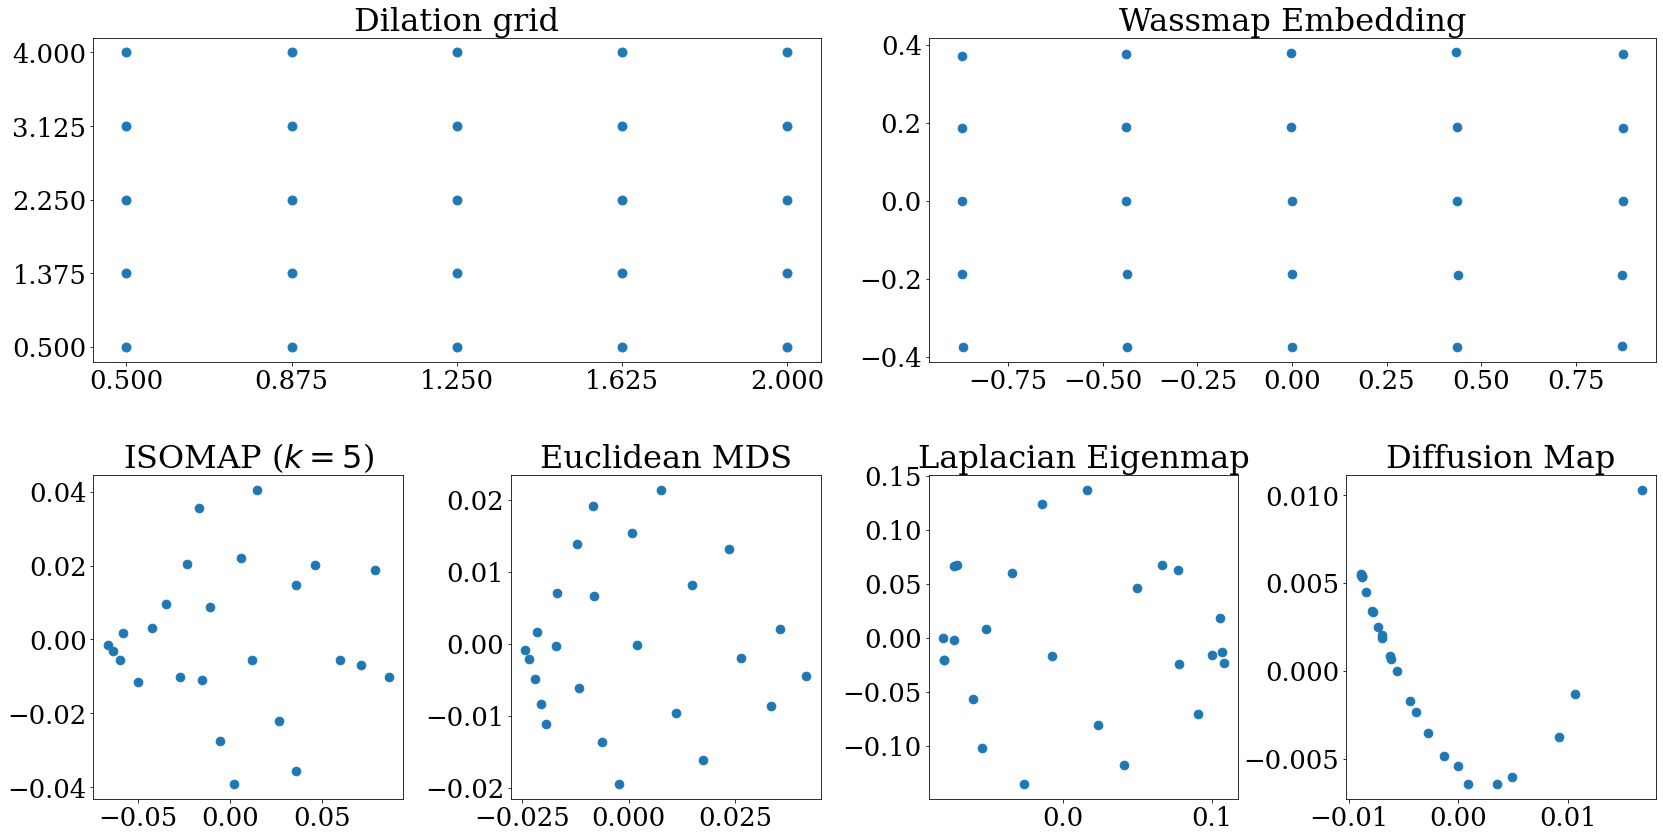

In [ ]:
### FIGURE 3: Circle dilation test 1:Plotting

# Create the plot objects 
fig3 = plt.figure(figsize=(28,14))
ax3 = fig3.subplot_mosaic(
    """
    AABB
    CDEF
    """,
    gridspec_kw = {"wspace":0.35,"hspace":0.35}
)

# Plot the dilation set 
ax3['A'].scatter(dilates[:,0],dilates[:,1],s=80)
ax3['A'].set_title('Dilation grid')
ax3['A'].set_xticks(x)
ax3['A'].set_yticks(y)

# Plot Wassmap embedding
scatter_x = WassEmbedding_dil[:,0]
scatter_y = WassEmbedding_dil[:,1]
ax3['B'].scatter(scatter_x,scatter_y,s=75)
ax3['B'].set_title('Wassmap Embedding')

# Plot the ISOMAP embedding
ax3['C'].scatter(IsomapEmbedding[:,0], IsomapEmbedding[:,1],s=75)
#ax3['C'].set_aspect('equal')
ax3['C'].set_title("ISOMAP ($k = %i$)"%isomap_k)
ax3['D'].scatter(EucEmbedding[:,0], EucEmbedding[:,1],s=75)
#ax3['D'].set_aspect('equal')
ax3['D'].set_title("Euclidean MDS")

# Plot the spectral embedding 
ax3['E'].scatter(SpecEmbedding[:,0],SpecEmbedding[:,1],s=75)
#ax3['E'].set_aspect('equal')
ax3['E'].set_title('Laplacian Eigenmap')
# Plot the diffusion map embedding 
ax3['F'].scatter(DMapEmbedding[:,0],DMapEmbedding[:,1],s=75)
#ax3['F'].set_aspect('equal')
ax3['F'].set_title('Diffusion Map')

# Save the figure to google drive 
fig3.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig3.pdf',bbox_inches='tight')

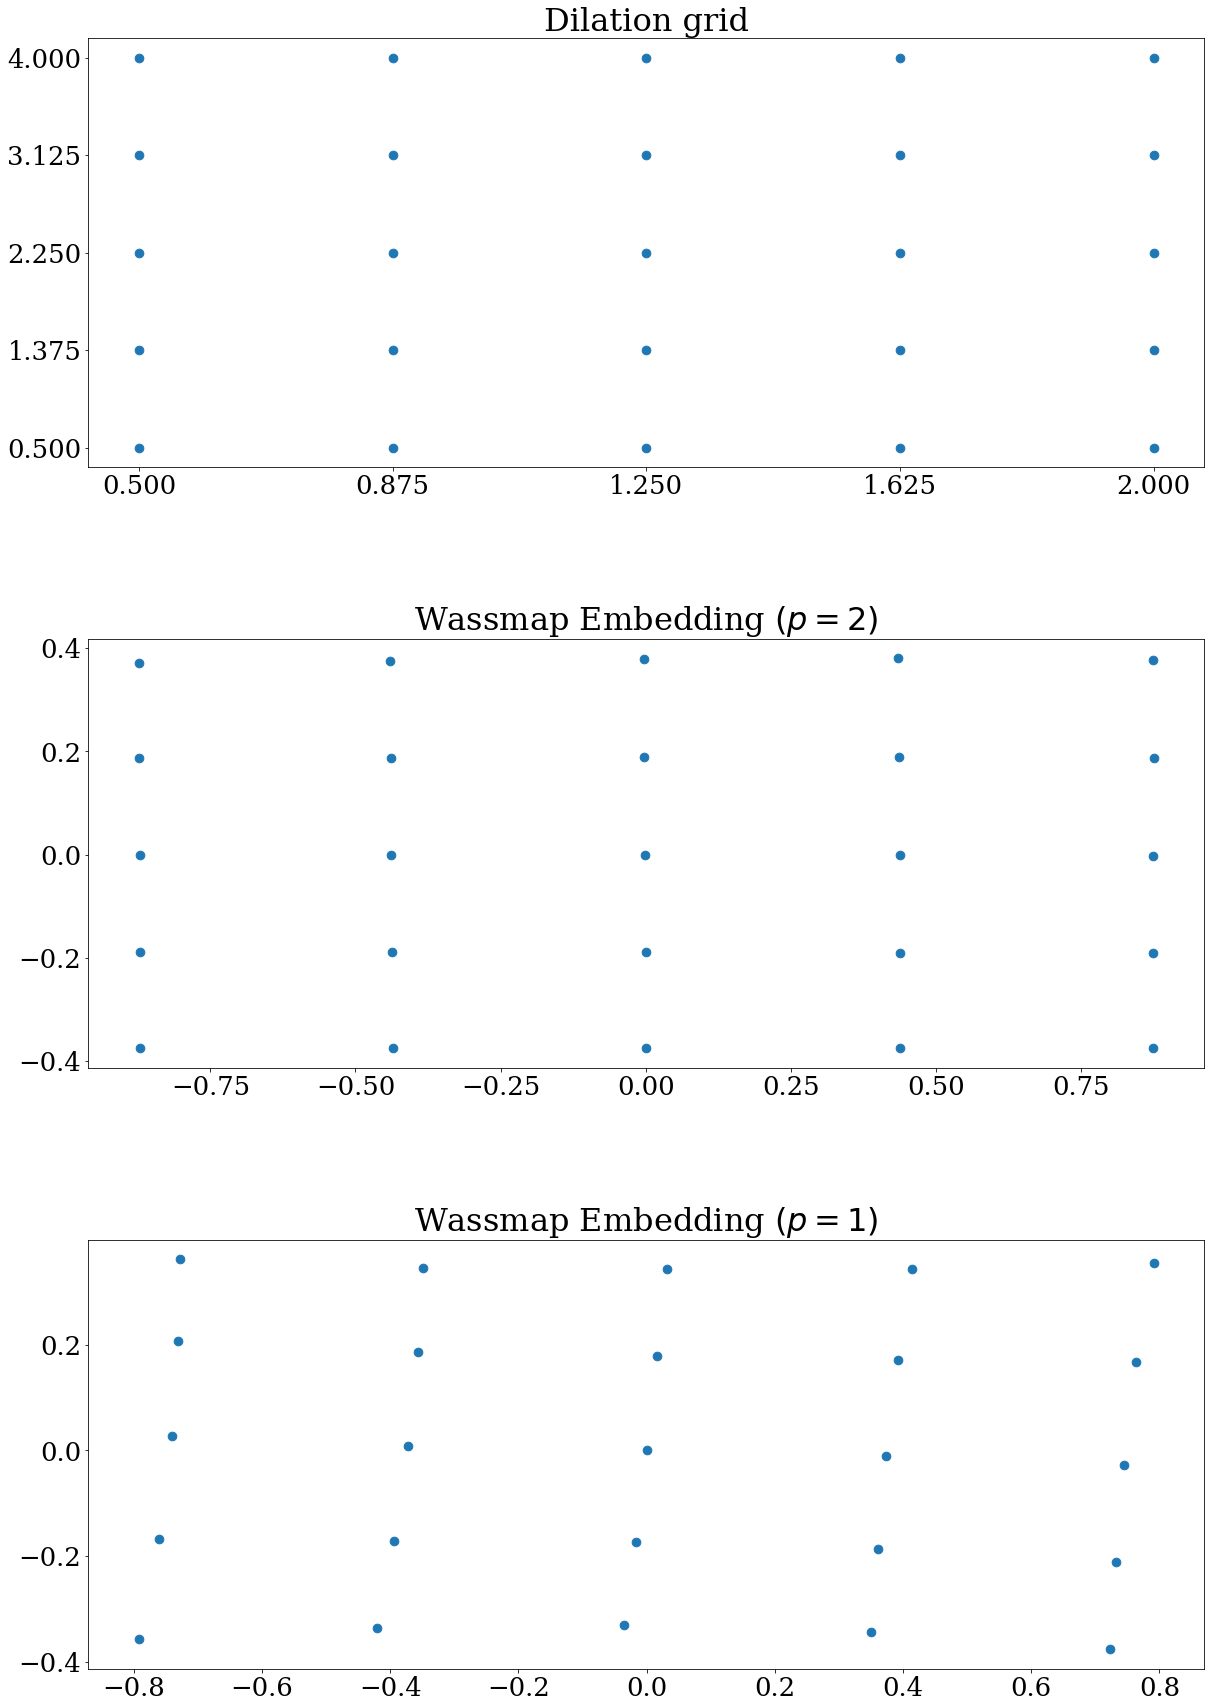

In [ ]:
### Supplemental dilation figure:Comparing Wass with p=1 to p=2:Plotting

# Create the plot objects 
fig3_supp = plt.figure(figsize=(20,30))
ax3 = fig3_supp.subplot_mosaic(
    """
    A
    B
    C
    """,
    gridspec_kw = {"wspace":0.6,"hspace":0.4}
)

# Plot the dilation set 
scatter_x = dilates[:,0]
scatter_y = dilates[:,1]
ax3['A'].scatter(scatter_x,scatter_y,s=75)
ax3['A'].set_title('Dilation grid')
ax3['A'].set_xticks(x)
ax3['A'].set_yticks(y)

# Plot Wassmap embedding
scatter_x = WassEmbedding_dil[:,0]
scatter_y = WassEmbedding_dil[:,1]
ax3['B'].scatter(scatter_x,scatter_y,s=75)
ax3['B'].set_title('Wassmap Embedding $(p=2)$')

# Plot the Wassmap embedding
scatter_x = WassEmbedding_p1[:,0]
scatter_y = WassEmbedding_p1[:,1]
ax3['C'].scatter(scatter_x,scatter_y,s=75)
ax3['C'].set_title('Wassmap Embedding $(p=1)$')

# Save the figure to google drive 
fig3_supp.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig3_supp.pdf',bbox_inches='tight')

In [ ]:
### FIGURE 4: Ellipse rotation test::Computations

# Generate ellipse
num_samplepoints = 64
ellipse = wm.generate_ellipse([0,0], 1, .5, samples = num_samplepoints)

# Generate translation set
num_rotations = 21
theta = np.linspace(0,2*np.pi,num=num_rotations,endpoint=False)
x = np.cos(theta)
y = np.sin(theta)
rotates = np.zeros((num_rotations,2))
for i in range(len(x)):
    rotates[i,0] = x[i]
    rotates[i,1] = y[i]
    
rot_images = []
for i in range(rotates.shape[0]):
    img = np.concatenate((wm.rotation(ellipse,theta[i]),np.ones((ellipse.shape[0],1))/ellipse.shape[0]),axis=1)
    rot_images.append(img)

# Generate voxel images (for ISOmap)
nvox = 256
xg = np.linspace(-6,6,nvox)
xxg,yyg = np.meshgrid(xg,xg,indexing='ij')
grid = np.stack((xxg,yyg))
rot_images_vox = np.zeros((nvox,nvox,len(rot_images)))
vox_matrix = np.zeros((num_rotations,nvox*nvox))
for i in range(len(rot_images)):
    pc = rot_images[i]
    rot_images_vox[:,:,i] = wm.pointcloud_to_vox(pc,grid)
    vox_matrix[i,:] = np.reshape(rot_images_vox[:,:,i],(1,nvox*nvox))

# Compute Wasserstein square distance matrix
wass_p = 2.0
tic = time.perf_counter()
Wass_distance_rot = wm.Wasserstein_Matrix(rot_images,squared=True,geodesic=False,p=wass_p)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_rotations,toc))


/usr/local/lib/python3.7/dist-packages/ot/lp/__init__.py:554: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  check_result(result_code)


Computed Wasserstein distance matrix (N = 21) in 468.3827 seconds


In [ ]:

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding_rot = wm.MDS(Wass_distance_rot,squared=True)

# Compute Euclidean distance matrix and MDS embedding
euc_matrix = wm.Euclidean_Matrix(rot_images_vox,geodesic=False,squared=True,plot=False)
EucEmbedding = wm.MDS(euc_matrix,squared=True)

# Compute the ISOMAP embedding 
isomap_k = 5
IsomapEmbedding = man.Isomap(n_components=2,n_neighbors=isomap_k).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap)
numneighbors = 10
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=numneighbors).fit_transform(vox_matrix)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
mydmap_wass = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0,k=10,metric='precomputed')
DMapEmbedding = mydmap.fit_transform(vox_matrix)

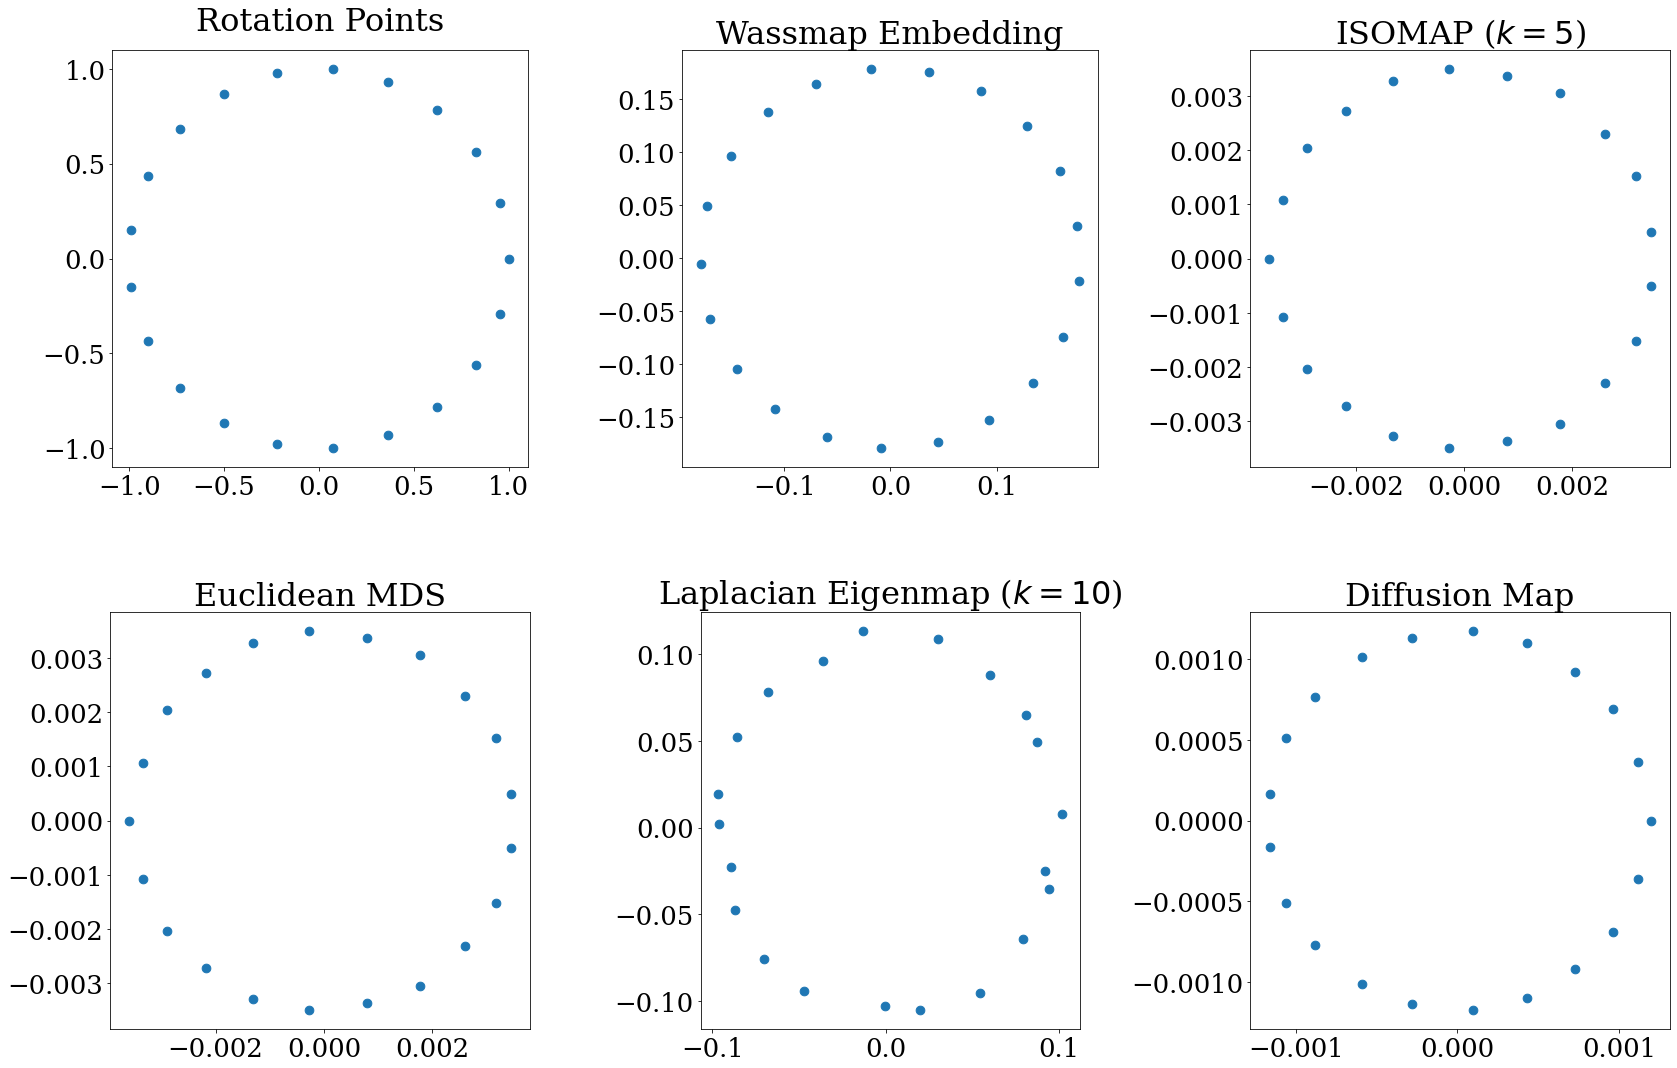

In [ ]:
### FIGURE 4: Ellipse rotation test:Plotting

# Create the figure 
fig4 = plt.figure(figsize=(28,18))
ax4 = fig4.subplot_mosaic(
    """
    ABC
    DEF
    """,
    gridspec_kw = {"wspace":0.35,"hspace":0.35}
)

# Plot the rotation set 
#fig4,ax4 = plt.subplots(2,4,figsize=(20,20))
ax4['A'].scatter(rotates[:,0],rotates[:,1],s=75)
ax4['A'].set_aspect('equal')
ax4['A'].set_title('Rotation Points',pad=20)

# Plot Wassmap embedding
scatter_x = WassEmbedding_rot[:,0]
scatter_y = WassEmbedding_rot[:,1]
ax4['B'].scatter(scatter_x,scatter_y,s=75)
ax4['B'].set_aspect('equal')
ax4['B'].set_title('Wassmap Embedding')

# Plot the ISOMAP embedding
ax4['C'].scatter(EucEmbedding[:,0], EucEmbedding[:,1],s=75)
ax4['C'].set_aspect('equal')
ax4['C'].set_title("ISOMAP ($k = %i$)"%isomap_k)

# Plot the MDS embedding
ax4['D'].scatter(EucEmbedding[:,0], EucEmbedding[:,1],s=75)
ax4['D'].set_aspect('equal')
ax4['D'].set_title("Euclidean MDS")

# Classic spectral embedding
ax4['E'].scatter(SpecEmbedding[:,0], SpecEmbedding[:,1],s=75)
ax4['E'].set_aspect('equal')
ax4['E'].set_title("Laplacian Eigenmap ($k = %i$)"%numneighbors)

# Plot the diffusion map embedding 
ax4['F'].scatter(DMapEmbedding[:,0],DMapEmbedding[:,1],s=75)
ax4['F'].set_aspect('equal')
ax4['F'].set_title('Diffusion Map')

# Save the figure to google drive 
fig4.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig4.pdf',bbox_inches='tight')

In [ ]:
# Plot some sample images 
ax4['C'].scatter(rot_images[0][:,0],rot_images[0][:,1])
ax4['C'].set_aspect('equal')
ax4['C'].set_xlim([-1,1])
ax4['C'].set_ylim([-1,1])
ax4['D'].scatter(rot_images[1][:,0],rot_images[1][:,1])
ax4['D'].set_aspect('equal')
ax4['D'].set_xlim([-1,1])
ax4['D'].set_ylim([-1,1])
ax4['E'].scatter(rot_images[2][:,0],rot_images[2][:,1])
ax4['E'].set_aspect('equal')
ax4['E'].set_xlim([-1,1])
ax4['E'].set_ylim([-1,1])
ax4['F'].scatter(rot_images[3][:,0],rot_images[3][:,1])
ax4['F'].set_aspect('equal')
ax4['F'].set_xlim([-1,1])
ax4['F'].set_ylim([-1,1])

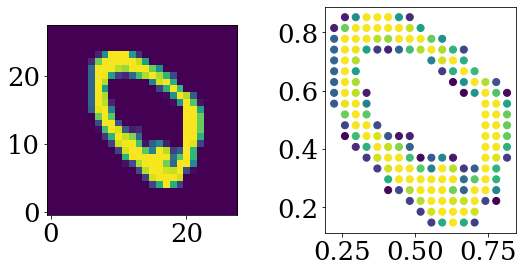

In [ ]:
# For mnist digits
from keras.datasets import mnist
(train_X,train_y), (test_X,test_y) = mnist.load_data()

# Break out individual digit classes
zeros = train_X[train_y==0]
ones = train_X[train_y==1]
twos = train_X[train_y==2]
threes = train_X[train_y==3]
fours = train_X[train_y==4]
fives = train_X[train_y==5]
sixes = train_X[train_y==6]
sevens = train_X[train_y==7]
eights = train_X[train_y==8]
nines = train_X[train_y==9]

# Create pointclouds 
nxg = 28
x = np.linspace(0,1,nxg)
xx,yy = np.meshgrid(x,x,indexing='ij')
grid = np.stack((xx,yy))

## NOTE: Need to have dynamic sizing for pointcloud tensor because output size of vox_to_pointcloud is not consistent
# Zeros
zeros_pointcloud = list()
for i in range(zeros.shape[0]):
    zeros_pointcloud.append(vox_to_pointcloud(zeros[i,:,:],grid))
# Ones
ones_pointcloud = list()
for i in range(ones.shape[0]):
    ones_pointcloud.append(vox_to_pointcloud(ones[i,:,:],grid))
# Twos
twos_pointcloud = list()
for i in range(twos.shape[0]):
    twos_pointcloud.append(vox_to_pointcloud(twos[i,:,:],grid))
# Threes
threes_pointcloud = list()
for i in range(threes.shape[0]):
    threes_pointcloud.append(vox_to_pointcloud(threes[i,:,:],grid))
# Fours
fours_pointcloud = list()
for i in range(fours.shape[0]):
    fours_pointcloud.append(vox_to_pointcloud(fours[i,:,:],grid))
# Fives
fives_pointcloud = list()
for i in range(fives.shape[0]):
    fives_pointcloud.append(vox_to_pointcloud(fives[i,:,:],grid))
# Sixes
sixes_pointcloud = list()
for i in range(sixes.shape[0]):
    sixes_pointcloud.append(vox_to_pointcloud(sixes[i,:,:],grid))
# Sevens
sevens_pointcloud = list()
for i in range(sevens.shape[0]):
    sevens_pointcloud.append(vox_to_pointcloud(sevens[i,:,:],grid))
# Eights
eights_pointcloud = list()
for i in range(eights.shape[0]):
    eights_pointcloud.append(vox_to_pointcloud(eights[i,:,:],grid))
# Nines
nines_pointcloud = list()
for i in range(nines.shape[0]):
    nines_pointcloud.append(vox_to_pointcloud(nines[i,:,:],grid))


fig,ax = plt.subplots(1,2)
fig.tight_layout()
ax[0].imshow(zeros[0,:,:],origin='lower')
ax[1].scatter(zeros_pointcloud[0][:,0],zeros_pointcloud[0][:,1],s=50,c=zeros_pointcloud[0][:,2])
ax[1].set_aspect(1)

In [ ]:
image_tensor = np.concatenate((zeros,ones))
print(zeros.shape)
print(image_tensor.shape)

(5923, 28, 28)
(12665, 28, 28)


minimum nonzero distance = 0.0212
minimum nonzero distance = 0.0212
Computed Wasserstein distance matrix (N = 25) in 171.4858 seconds


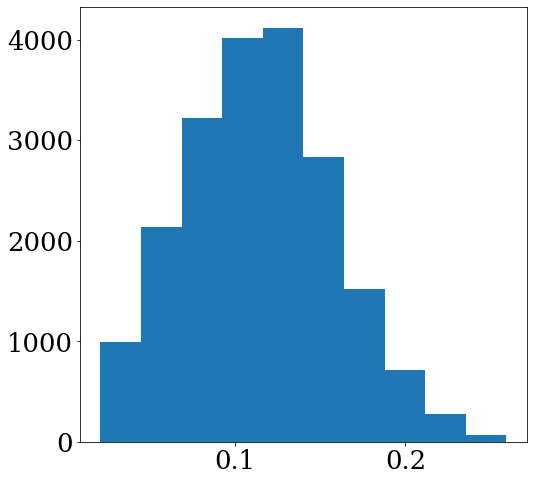

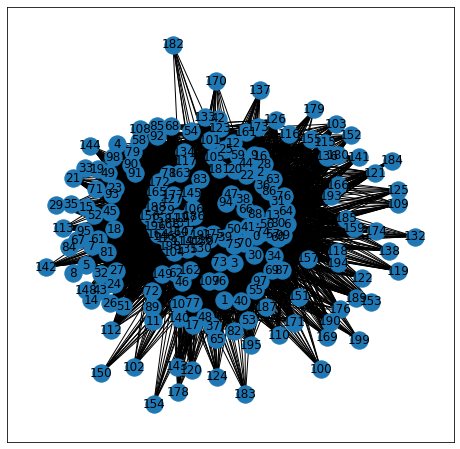

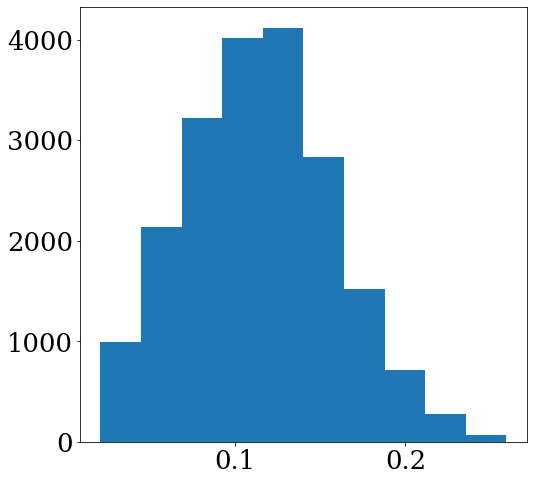

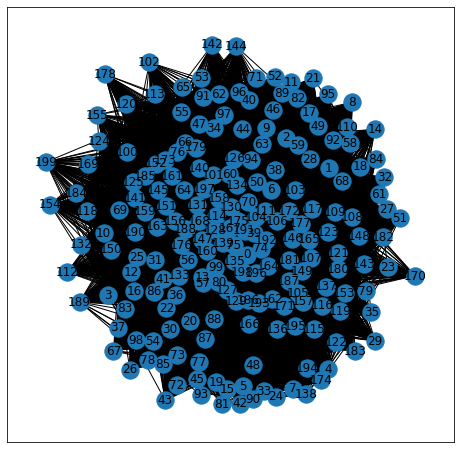

In [ ]:
### FIGURE 6: MNIST DIGITS 

# Select random digits 
numdigits = 100
random_zeros  = np.random.choice(range(len(zeros_pointcloud)),size=numdigits,replace=False)
random_ones   = np.random.choice(range(len(ones_pointcloud)),size=numdigits,replace=False)
random_twos   = np.random.choice(range(len(twos_pointcloud)),size=numdigits,replace=False)
random_threes = np.random.choice(range(len(threes_pointcloud)),size=numdigits,replace=False)
random_fours  = np.random.choice(range(len(fours_pointcloud)),size=numdigits,replace=False)
random_fives  = np.random.choice(range(len(fives_pointcloud)),size=numdigits,replace=False)
random_sixes  = np.random.choice(range(len(sixes_pointcloud)),size=numdigits,replace=False)
random_sevens = np.random.choice(range(len(sevens_pointcloud)),size=numdigits,replace=False)
random_eights = np.random.choice(range(len(eights_pointcloud)),size=numdigits,replace=False)
random_nines  = np.random.choice(range(len(nines_pointcloud)),size=numdigits,replace=False)

digits = list()

for i in random_ones:
    digits.append(ones_pointcloud[i])
for i in random_sevens:
    digits.append(sevens_pointcloud[i])
#for i in random_twos:
#    digits.append(twos_pointcloud[i])

total_num = len(digits)
# Compute Wasserstein square distance matrix
tic = time.perf_counter()
Wass_distance = Wasserstein_Matrix(digits,squared=True,geodesic=False)
wass_eps_1 = 0.14
wass_eps_2 = 0.1
Wass_distance_geo_1 = Wasserstein_Matrix(digits,squared=True,geodesic=True,eps=wass_eps_1,plot=True)
Wass_distance_geo_2 = Wasserstein_Matrix(digits,squared=True,geodesic=True,eps=wass_eps_2,plot=True)
toc = time.perf_counter() - tic
print("Computed Wasserstein distance matrix (N = %i) in %0.4f seconds"%(num_samp,toc))

# MDS on Wass squared matrix to obtain the Wassmap embedding
WassEmbedding       = MDS(Wass_distance,squared=True)
WassEmbedding_geo_1 = MDS(Wass_distance_geo_1,squared=True)
WassEmbedding_geo_2 = MDS(Wass_distance_geo_2,squared=True)



In [ ]:
# Build the image tensor & reshape for sklearn
image_tensor = np.concatenate((ones,twos,sevens))
nvox = 28
vox_matrix = np.zeros((total_num,nvox*nvox))
for i in range(total_num):
    vox_matrix[i,:] = np.reshape(image_tensor[i,:,:],(1,nvox*nvox))
# Compute isomap using sklearn 
isomap_k_1 = 3
EucEmbedding_skl_1 = man.Isomap(n_components=2,n_neighbors=isomap_k_1).fit_transform(vox_matrix)
isomap_k_2 = 6
EucEmbedding_skl_2 = man.Isomap(n_components=2,n_neighbors=isomap_k_2).fit_transform(vox_matrix)
isomap_k_3 = 20
EucEmbedding_skl_3 = man.Isomap(n_components=2,n_neighbors=isomap_k_3).fit_transform(vox_matrix)

# Compute the spectral embedding (AKA Laplacian Eigenmap)
numneighbors = 6
SpecEmbedding = man.SpectralEmbedding(n_components=2,affinity='nearest_neighbors',n_neighbors=numneighbors).fit_transform(vox_matrix)

# Compute the diffusion map 
neighbor_params = {'n_jobs': -1, 'algorithm': 'kd_tree'} 
mydmap = dm.DiffusionMap.from_sklearn(n_evecs = 2, epsilon = 'bgh', alpha = 1.0, neighbor_params = neighbor_params)
DMapEmbedding = mydmap.fit_transform(vox_matrix)

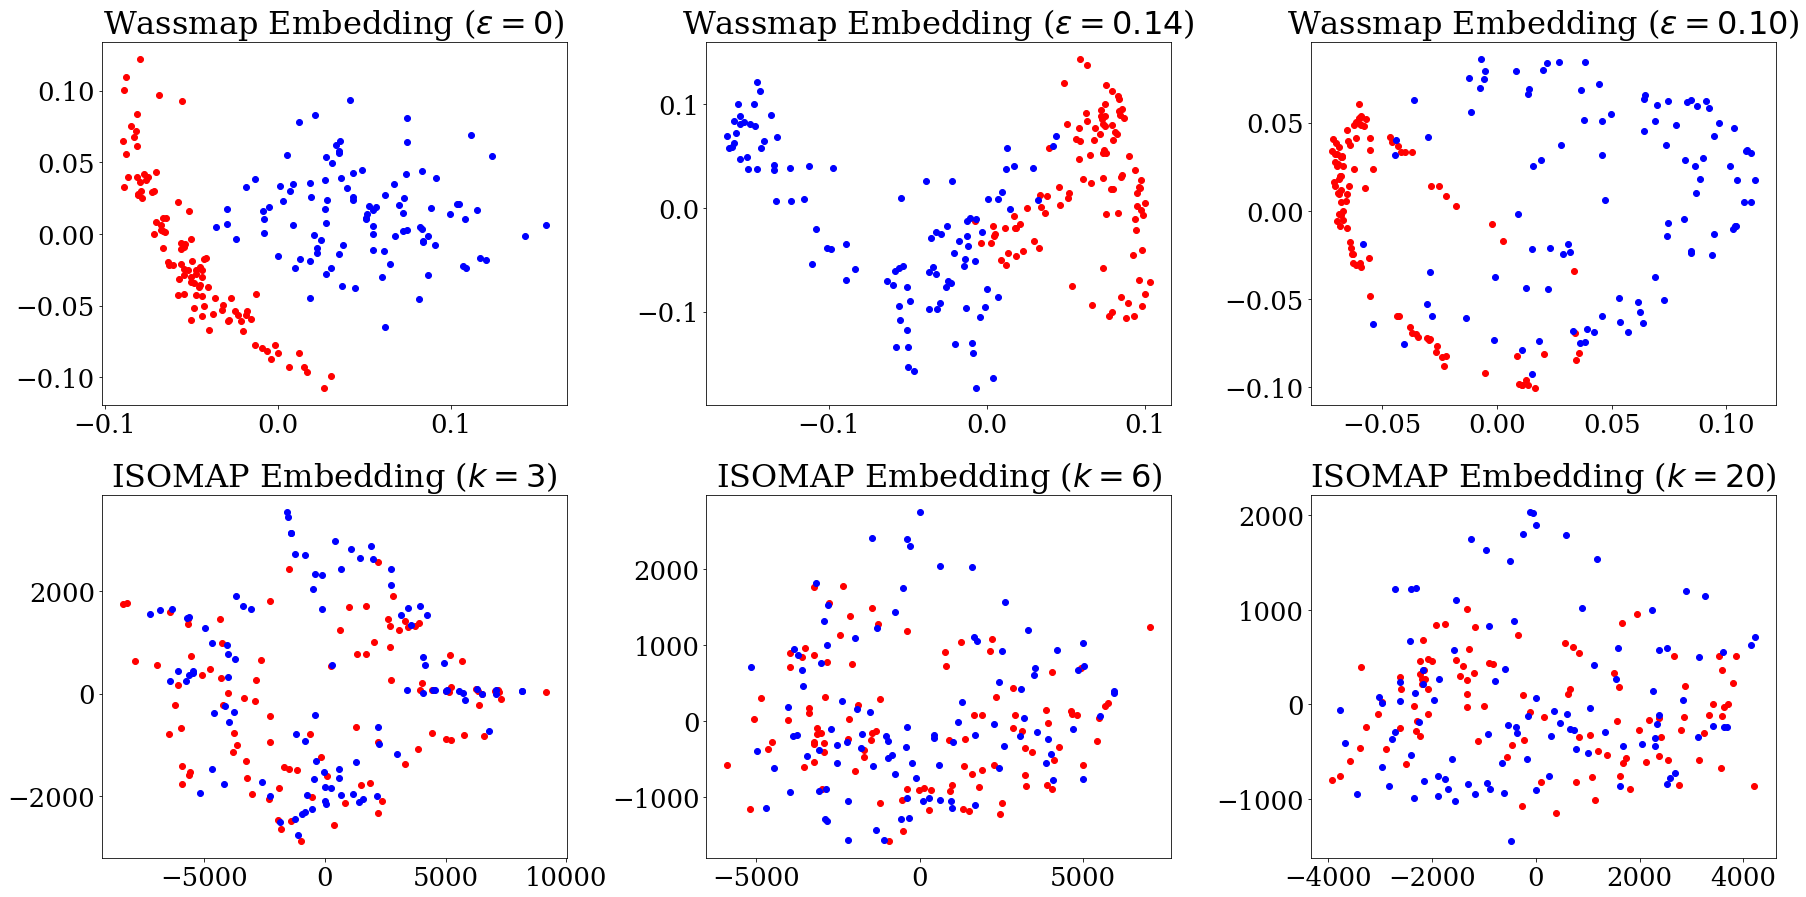

In [ ]:
# Plotting
fig, ax = plt.subplots(2,3,figsize=(30,15),
    gridspec_kw = {"wspace":0.3,"hspace":0.25})
num_zeros = len(random_zeros)
num_ones = len(random_ones)
num_twos = len(random_twos)
num_sevens = len(random_sevens)
#num_twos = len(random_twos)

L = num_ones
M = num_sevens
N = num_twos

ax[0,0].scatter(WassEmbedding[range(L),0],WassEmbedding[range(L),1],c='r')
ax[0,0].scatter(WassEmbedding[range(L,L+M),0],WassEmbedding[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,0].set_title("Wassmap Embedding ($\epsilon=0$)")

ax[0,1].scatter(WassEmbedding_geo_1[range(L),0],WassEmbedding_geo_1[range(L),1],c='r')
ax[0,1].scatter(WassEmbedding_geo_1[range(L,L+M),0],WassEmbedding_geo_1[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,1].set_title("Wassmap Embedding ($\epsilon=%1.2f$)"%wass_eps_1)

ax[0,2].scatter(WassEmbedding_geo_2[range(L),0],WassEmbedding_geo_2[range(L),1],c='r')
ax[0,2].scatter(WassEmbedding_geo_2[range(L,L+M),0],WassEmbedding_geo_2[range(L,L+M),1],c='b')
#ax[0,0].scatter(WassEmbedding[range(L+M,L+M+N),0],WassEmbedding[range(L+M,L+M+N),1],c='g')
ax[0,2].set_title("Wassmap Embedding ($\epsilon=%1.2f$)"%wass_eps_2)

ax[1,0].scatter(EucEmbedding_skl_1[range(L),0],EucEmbedding_skl_1[range(L),1],c='r')
ax[1,0].scatter(EucEmbedding_skl_1[range(L,L+M),0],EucEmbedding_skl_1[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,0].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_1)

ax[1,1].scatter(EucEmbedding_skl_2[range(L),0],EucEmbedding_skl_2[range(L),1],c='r')
ax[1,1].scatter(EucEmbedding_skl_2[range(L,L+M),0],EucEmbedding_skl_2[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,1].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_2)

ax[1,2].scatter(EucEmbedding_skl_3[range(L),0],EucEmbedding_skl_3[range(L),1],c='r')
ax[1,2].scatter(EucEmbedding_skl_3[range(L,L+M),0],EucEmbedding_skl_3[range(L,L+M),1],c='b')
#ax[0,1].scatter(EucEmbedding_skl[range(L+M,L+M+N),0],EucEmbedding_skl[range(L+M,L+M+N),1],c='g')
ax[1,2].set_title("ISOMAP Embedding ($k = %i$)"%isomap_k_3)

#ax[1,1].scatter(SpecEmbedding[range(L),0],SpecEmbedding[range(L),1],c='r')
#ax[1,1].scatter(SpecEmbedding[range(L,L+M),0],SpecEmbedding[range(L,L+M),1],c='b')
#ax[1,0].scatter(SpecEmbedding[range(L+M,L+M+N),0],SpecEmbedding[range(L+M,L+M+N),1],c='g')
#ax[1,1].set_title("Laplacian Eigenmap Embedding ($k = %i$)"%numneighbors)

#ax[1,2].scatter(DMapEmbedding[range(L),0],DMapEmbedding[range(L),1],c='r')
#ax[1,2].scatter(DMapEmbedding[range(L,L+M),0],DMapEmbedding[range(L,L+M),1],c='b')
#ax[1,1].scatter(DMapEmbedding[range(L+M,L+M+N),0],DMapEmbedding[range(L+M,L+M+N),1],c='g')
#ax[1,2].set_title("Diffusion Map Embedding ")

plt.savefig('/content/drive/My Drive/Colab Notebooks/figures/revisions/fig6.pdf',bbox_inches='tight')